Running on device: mps
Sequential(
  (0): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
  )
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Sequential(
    (0): Linear(in_features=3136, out_features=1000, bias=True)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
 

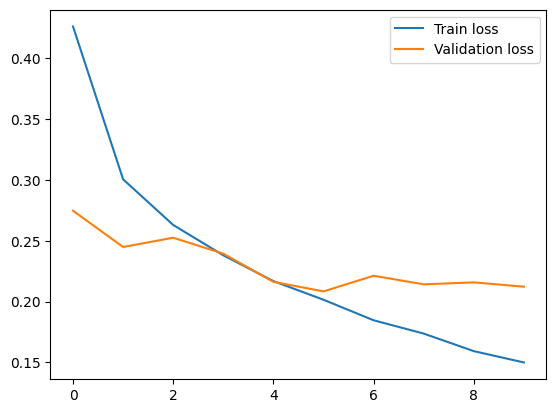

In [1]:
import sys
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
print("Running on device:", device)

mnist_train = datasets.FashionMNIST(root='./data', download=True, train=True, transform=ToTensor())
mnist_test = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, padding_mode="reflect"),
        nn.MaxPool2d(kernel_size=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(0.1)
    ),
    nn.Flatten(),
    nn.Sequential(
        nn.Linear(64 * 7 * 7, 1000),
        nn.BatchNorm1d(1000),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1000, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(100, 10)
    )
).to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

for i in range(0, 10):
    model.train()
    loss_sum = 0
    for X, y in train_dataloader:
        y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
        X = X.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    train_losses.append(loss_sum / len(train_dataloader))

    val_loss_sum = 0
    model.eval()
    with torch.no_grad():
        for X, y in test_dataloader:
            y = F.one_hot(y, num_classes=10).type(torch.float32).to(device)
            X = X.to(device)
            outputs = model(X)
            val_loss_sum += loss_fn(outputs, y).item()
    val_losses.append(val_loss_sum / len(test_dataloader))

    # Save the model checkpoint for this epoch
    torch.save(model.state_dict(), f"model_{i}.pth")

# Plot train_losses and val_losses, add legend, and save the figure
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.savefig('final.png')

model.eval()
with torch.no_grad():
    accurate = 0
    total = 0
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        outputs = nn.functional.softmax(model(X), dim=1)
        correct_pred = (y == outputs.max(dim=1).indices)
        total += correct_pred.size(0)
        accurate += correct_pred.type(torch.int).sum().item()
    print("Accuracy on validation data:", accurate / total)